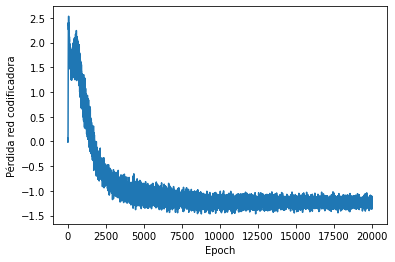

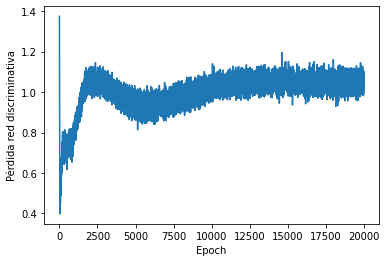

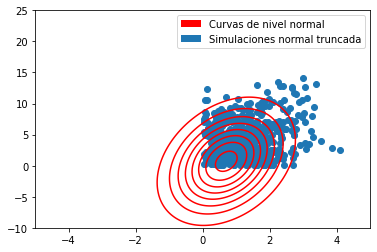

Segundos:  993.15
Minutos:  16.55

Segundos muestreo:  0.032135


In [3]:
# AVB, normal truncada, priori gamma

import os
import pystan
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from tensorflow.python.framework import ops
#pip install ite
import ite
from tqdm import tqdm_notebook
import re
import glob
import tensorflow as tf
import tensorflow_probability as tfp
import time
from scipy.stats import multivariate_normal as mvn


tf.random.set_seed(289612)

tam=500 # tamaño muestra aproximante

t_ini=time.time()

# Parameters
batch_size = 512 
data = {'J': 2, # dimensión de distribución posterior
        'a': [1e-8, 1e-8], # límite inferior de normal truncada
        'mu': [1./2.**0.5,  1./2.**0.5],
       'sigma': [1., 5.],
       'rho': 0.33}
alf=1. # parámetro distribución a priori
lam =0.5 # parámetro distribución a priori


param_dim = 2 # dimensión de parámetro

def get_logprob(z, data):
    x1 = z[:, 0:1]
    x2 = z[:, 1:2]

    a = tf.constant(data['a'], dtype=tf.float32, shape=(1, data['J']))
    mu = tf.constant(data['mu'], dtype=tf.float32, shape=(1, data['J']))
    sigma = tf.constant(data['sigma'], dtype=tf.float32, shape=(1, data['J']))
    rho = tf.constant(data['rho'], dtype=tf.float32, shape=(1, 1))
    e1 = (x1-mu[:,0])/sigma[:,0]
    e2 = (x2-mu[:,1])/sigma[:,1]

    logprob = tf.reduce_sum(
        -0.5/(1-tf.square(rho)) *( tf.square(e1) + tf.square(e2) - 2.*rho*e1*e2 ), [1]
    ) # logaritmo de kernel normal truncada
    logprob += tf.reduce_sum(lam*x1 - (alf-1)*tf.math.log(lam*x1), [1]) # menos logaritmo de kernel gamma
    logprob += tf.reduce_sum(lam*x2 - (alf-1)*tf.math.log(lam*x2), [1]) # menos logaritmo de kernel gamma
    
    return logprob



red_posterior =  tf.keras.Sequential(
        [
         tf.keras.layers.Dense(128, activation=tf.nn.elu),
         tf.keras.layers.Dense(128, activation=tf.nn.elu),
         tf.keras.layers.Dense(param_dim, activation=tf.nn.relu),
        ]
    )

def posterior(num):
        eps = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros([num, param_dim]), scale_diag=tf.ones([num, param_dim])).sample()
        z=red_posterior(eps)
        return z

red_adversaria =  tf.keras.Sequential(
        [
         tf.keras.layers.Dense(256, activation=tf.nn.elu),
         tf.keras.layers.Dense(256, activation=tf.nn.elu),
         tf.keras.layers.LeakyReLU(alpha=0.2),
         tf.keras.layers.Dense(1,activation=None,kernel_initializer=tf.keras.initializers.zeros()),
        ]
    )

def adversary(z):
  T = red_adversaria(z)
  T = tf.squeeze(T, [1])
  return T

def compute_loss():
  z0 = tf.random.gamma([batch_size, param_dim],alpha=tf.constant(alf),beta=tf.constant(lam))
  a = tf.constant(data['a'], dtype=tf.float32, shape=(1, data['J']))
  z_ = posterior(batch_size)
  z_ = a + z_

  Ti = adversary(z0)
  Td = adversary(z_)


  logprob = get_logprob(z_, data)
  mean_logprob = tf.reduce_mean(logprob)
  mean_Td = tf.reduce_mean(Td)
  loss_primal = tf.reduce_mean((Td) - logprob)

  d_loss_d = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=Td, labels=tf.ones_like(Td))
  )
  d_loss_i = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=Ti, labels=tf.zeros_like(Ti))
  )
  loss_dual = d_loss_i + d_loss_d

  return loss_primal, loss_dual

optimizer_gen = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
optimizer_disc = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

@tf.function
def train_step(red_posterior, red_adversaria, optimizer_gen, optimizer_disc):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    loss_aux = compute_loss()
    loss = loss_aux[0]
    disc_loss = loss_aux[1]
  gradients_gen = gen_tape.gradient(loss, red_posterior.trainable_variables)
  gradients_disc = disc_tape.gradient(disc_loss, red_adversaria.trainable_variables)
  optimizer_gen.apply_gradients(zip(gradients_gen, red_posterior.trainable_variables))
  optimizer_disc.apply_gradients(zip(gradients_disc, red_adversaria.trainable_variables))

n_epoch = 20000



vec_gen=np.array([])
vec_disc=np.array([])
for epoch in range(1, n_epoch + 1):
  start_time = time.time()
  train_step(red_posterior, red_adversaria, optimizer_gen, optimizer_disc)
  end_time = time.time()

  aux_loss=compute_loss()
  gen_loss=aux_loss[0]
  disc_loss=aux_loss[1]
  vec_gen=np.concatenate([vec_gen,np.array([gen_loss])])
  vec_disc=np.concatenate([vec_disc,np.array([disc_loss])])

t_fin=time.time()

def muestra(red_posterior,num):
  z_ = posterior(num)
  return z_

plt.figure()
plt.plot(np.arange(0,n_epoch), np.asarray(vec_gen[0:]))
plt.xlabel('Epoch')
plt.ylabel('Pérdida red codificadora')
plt.show()

plt.figure()
plt.plot(np.arange(0,n_epoch), np.asarray(vec_disc[0:]))
plt.xlabel('Epoch')
plt.ylabel('Pérdida red discriminativa')
plt.show()

t_ini_m=time.time()
n_vis = 1
enc_test = np.vstack([muestra(red_posterior,tam) for _ in range(n_vis)])
t_fin_m=time.time()




sigm=data['sigma']
mu_q=data['mu']
rh=data['rho']
A_q=np.array([[sigm[0]**2,rh*sigm[0]*sigm[1]],[rh*sigm[0]*sigm[1],sigm[1]**2]])

inf1=-5
sup1=5

inf2=-10
sup2=25

xx, yy = np.meshgrid(np.linspace(inf1,sup1,1000),np.linspace(inf2,sup2,1000))
xy = np.column_stack([xx.flat, yy.flat])

# density values at the grid points
Z_q = mvn.pdf(xy, mu_q, A_q).reshape(xx.shape)


cs=plt.contour(xx, yy, Z_q, levels = 10, colors="red")
sc=plt.scatter(enc_test[:,0], enc_test[:,1])
proxy = [plt.Rectangle((1, 1), 2, 2, fc="red"), plt.Circle(1, fc=sc.get_facecolor()[0]) ]
plt.legend(proxy, ["Curvas de nivel normal", "Simulaciones normal truncada"])
plt.show()

print('Segundos: ', np.round(t_fin-t_ini,decimals=2))
print('Minutos: ', np.round((t_fin-t_ini)/60.,decimals=2))
print("")
print('Segundos muestreo: ', np.round(t_fin_m-t_ini_m,decimals=6))
